# Electricity Demand Forecasting

This notebook details some basic code to get a simple time series forecasting algorithm up and running. The focus here is not an optimised algorithm, but to create a simple base model from which we can explore the concepts of machine learning engineering in the rest of the book.

# Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit

c:\Users\pedro\OneDrive\Documentos\ml-engineer-with-python\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('../data/AEP_hourly.csv')

In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


<Axes: xlabel='Datetime'>

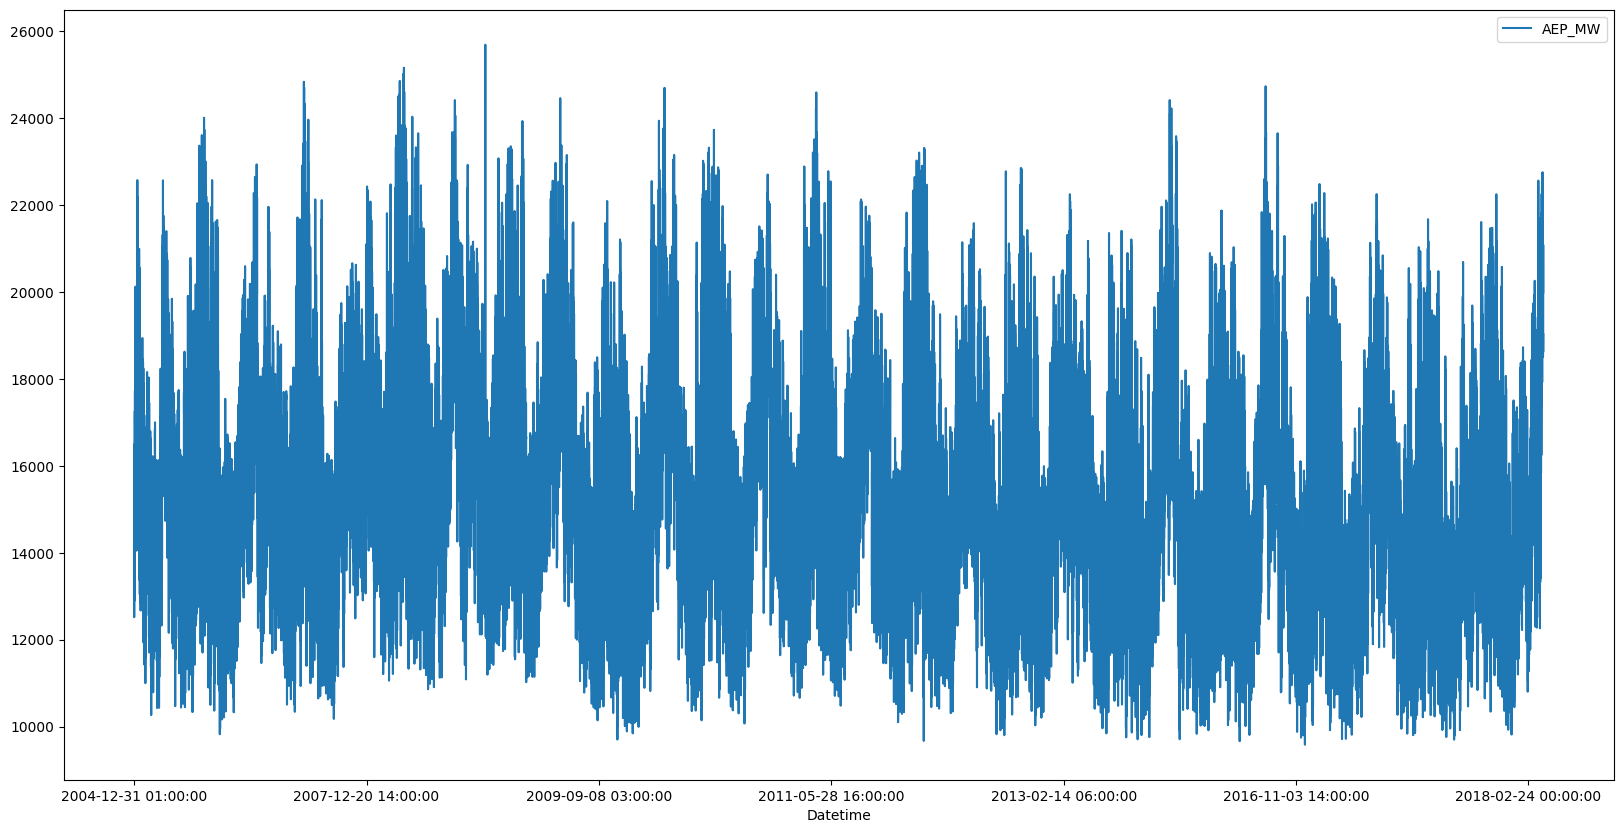

In [4]:
df.plot(x = 'Datetime', y = 'AEP_MW', figsize = (20, 10))

# Functions

In [6]:
seasonality = {
    'yearly': True,
    'weekly': True,
    'daily': True
}
def time_split_train_test(df, time_series_splits, seasonality=seasonality):
    # for outputting
    df_results = pd.DataFrame()
    
    for i, (train_i,test_i) in enumerate(time_series_splits.split(df)):
        
        # grab split data
        df_train = df.copy().iloc[train_i,:]
        df_test = df.copy().iloc[test_i,:]

        # create Prophet model
        model=Prophet(
            yearly_seasonality=seasonality['yearly'],
            weekly_seasonality=seasonality['weekly'],
            daily_seasonality=seasonality['daily']
        )

        # train and predict
        model.fit(df_train)
        predicted = model.predict(df_test)

        # combine pred and training df's for plotting
        df_pred = predicted.loc[:,["ds","yhat"]]
        
        df_pred["y"] = df_test['y'].tolist()
        
        # Train or Test?
        df_train["train"]=True
        df_pred["train"]=False
        
        df_sub = df_train.append(df_pred).reset_index(drop=True)
        df_sub["split"]=i
        df_sub["rmse"]=(np.mean((df_sub.yhat-df_sub.y)**2))**.5 #calculating rmse for the split
        
        df_results = df_results.append(df_sub).reset_index(drop=True)
    return df_results

# Prep for Prophet

In [7]:
df.rename(columns = {'Datetime': 'ds', 'AEP_MW': 'y'}, inplace = True)

In [8]:
df['ds'] = df['ds'].astype('datetime64[ns]')

In [9]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [10]:
# Initialize Split class and split data 5 times for cross validation
ts_splits = TimeSeriesSplit(n_splits = 5)

# Train and Forecast

In [11]:
tmp = time_split_train_test(df.sort_values('ds', ascending = True).iloc[-1000:], ts_splits)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


RuntimeError: Error during optimizing, error code 3221225785

In [ ]:
tmp.head()

# Plot

In [ ]:
nrow = 5; ncol = 1;
fig, axs = plt.subplots(nrows = nrow, ncols = ncol, figure = (20, 30))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i, ax in enumerate(fig.axes):
    split_rmse = tmp[(tmp['split'] == i) & (tmp['train'] == False)]['rmse'].iloc[0]
    ax.set_title('Split ' + str(i) + ' - RMSE:'+ "{:.2f}".format(split_rmse))
    tmp[(tmp['split']==i) & (tmp['train']==True)].plot(x='ds', y='y', ax=ax, color='blue', marker='o')
    tmp[(tmp['split']==i) & (tmp['train']==False)].plot(x='ds', y='y', ax=ax, color='red', marker='o')
    tmp[(tmp['split']==i) & (tmp['train']==False)].plot(x='ds', y='yhat', ax=ax, color='orange', marker='^')


In [ ]:
# winner is split 3 - so what are the sizes we select? 
model_config = {'train_size': 668, 'forecast_horizon': 100}